##Hyperparameters for the model:

In [ ]:
max_epochs = 1#000 #Maximum number of epochs
learning_rate = 0.005
hidden_feat_num = 20 #Was 20, then 40
batch_size = 1
layers = "lstm"

lang_list = [1,2]#list(range(1,11)) #This doesn't actually change the language--just tells you how many reps you're doing
token_per_type = 4
windows = (.75, .25)  #This is a tuple that's N long (where N is the size of the window stress can appear in) 
                      #with each number representing the proportion of the time that that syllable is stressed.
window_side = "R" #Will the window be from the right or left side of the word? ("L" for left, "R" for right)

#Dictionary that maps from feature values in the SR to segments
feats2symbol_sr = {
                      "1,1":"1",
                      "1,-1":"0",
                      "-1,-1":"E" 
                  }

#Mount the user's google drive:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


##Import the necessary packages:

In [ ]:
#CD into our google drive so we can use the custom Seq2Seq package
%cd gdrive/My Drive

import numpy as np
from keras import backend
import Seq2Seq

from re import sub, search
from random import choice, shuffle
from itertools import product
from matplotlib.pyplot import plot
from IPython.display import clear_output


/content/gdrive/My Drive


##Functions for processing the training data

In [ ]:
def get_strings(input_fn, copies=1):
  input_file = open("/content/gdrive/My Drive/NN_Stress/Input_Files/"+input_fn)
  input_file.readline()
  UR_strings = []
  SR_strings = []
  syll_lengths = []
  for line in input_file.readlines():
    columns = line.split(",")
    if len(columns) == 1:
      raw_ur = line.rstrip() 
    if len(columns) == 3:
      raw_sr = columns[1]
      raw_p = columns[2]
      ur, sr, p = sub("\"|\[|\]", "", raw_ur), sub("\[|\]", "", raw_sr), raw_p.rstrip()
      if p == "1":
        syll_lengths.append(len(ur.split(" ")))
        UR_strings.append(ur)
        new_sr = []
        for syll in sr.split(" "):
          new_syll = {"L1":"1", "H1":"1", "L2":"2", "H2":"2", "L":"0", "H":"0"}[syll]
          new_sr.append(new_syll)
        SR_strings.append(" ".join(new_sr))

  if copies > 1 and len(windows) > 0:
    lexical_labels = [c for c in range(1,1+(copies*len(UR_strings)))]
    shuffle(lexical_labels)
    token_UR_strings = []
    token_SR_strings = []
    token_syll_lengths = []
    for i, ur in enumerate(UR_strings):
      old_sr = SR_strings[i]

      #Window-based stress:
      these_patterns = [] #List of indeces showing where, on each copy the stress happens
      for j, p in enumerate(windows):
        num_tokens = p*copies
        if num_tokens % 1 != 0:
          raise Exception("Window proportions do not make integers with copy number!")
        for k in range(int(num_tokens)):
          these_patterns.append(j)
      shuffle(these_patterns)
      for copy in range(copies):
        this_label = str(lexical_labels.pop())
        token_UR_strings.append(ur+"_"+this_label)

        #Create SR based on window size:
        new_sr = []
        this_pattern = these_patterns.pop()
        if window_side == "L":
          for j, syll in enumerate(old_sr.split(" ")):
            if j == this_pattern:
              new_sr.append("1")
            else:
              new_sr.append("0")
        elif window_side == "R":
          window_counter = 0
          for j, syll in enumerate(old_sr.split(" ")):
            if j >= len(old_sr.split(" "))-len(windows) and window_counter == this_pattern:
              new_sr.append("1")
              window_counter += 1
            elif j >= len(old_sr.split(" "))-len(windows):
              new_sr.append("0")
              window_counter += 1
            else:
              new_sr.append("0")
        else:
          raise Exception("The variable window_side must be 'L' or 'R'!")

        #print(old_sr, "->", " ".join(new_sr), "...", this_pattern, "!!", ur)
        token_SR_strings.append(" ".join(new_sr))
        token_syll_lengths.append(syll_lengths[i])
    return token_UR_strings, token_SR_strings, token_syll_lengths

  return UR_strings, SR_strings, syll_lengths

def get_arrays(UR_strings, SR_strings, syll_lengths):
  symbol2feats_ur = {
                  #Syll	#Heavy
              "L":[	1.,		-1.],
              "H":[	1.,		1.],
              "E":[	-1.,		-1.]
            }
  symbol2feats_sr = {}
  for feat_bundle in feats2symbol_sr.keys():
    these_feats = [float(f) for f in feat_bundle.split(",")]
    symbol2feats_sr[feats2symbol_sr[feat_bundle]] = these_feats

  if "_" in "".join(UR_strings):
    #If we're using lexical features:
    real_strings = []
    raw_lex_nums = []
    max_lexLen = -1
    for ur in UR_strings:
      real_string, lex_num = ur.split("_")
      real_strings.append(real_string)
      bin_lex_num = str(bin(int(lex_num)).replace("0b", ""))
      raw_lex_nums.append(bin_lex_num)
      if len(bin_lex_num) > max_lexLen:
        max_lexLen = len(bin_lex_num)
    lex_nums = []
    for ln in raw_lex_nums:
      zeros = "0" * (max_lexLen - len(ln))
      lex_nums.append([float(digit) for digit in zeros+ln])

    max_len = max(syll_lengths)
    X_list = []
    Y_list = []
    for word_index, syll_length in enumerate(syll_lengths):
      padding = " ".join(["E"]*(max_len-syll_length))
      this_length = len(real_strings[word_index].split(" "))
      this_ur = real_strings[word_index]+" "+padding
      this_sr = SR_strings[word_index]+" "+padding
      X_list.append([symbol2feats_ur[seg]+lex_nums[word_index] for seg in this_ur.split(" ") if seg != ""])
      Y_list.append([symbol2feats_sr[seg] for seg in this_sr.split(" ") if seg != ""])
  else:
    max_len = max(syll_lengths)
    X_list = []
    Y_list = []
    for word_index, syll_length in enumerate(syll_lengths):
      padding = " ".join(["E"]*(max_len-syll_length))
      this_length = len(UR_strings[word_index].split(" "))
      this_ur = UR_strings[word_index]+" "+padding
      this_sr = SR_strings[word_index]+" "+padding
      X_list.append([symbol2feats_ur[seg] for seg in this_ur.split(" ") if seg != ""])
      Y_list.append([symbol2feats_sr[seg] for seg in this_sr.split(" ") if seg != ""])

  X = np.array(X_list)
  Y = np.array(Y_list)

  return X, Y


def get_test_arrays (UR_strings, syll_lengths):
  symbol2feats_ur = {
                #Syll	#Heavy
            "L":[	1.,		-1.],
            "H":[	1.,		1.],
            "E":[	-1.,		-1.]
          }
  real_strings = []
  raw_lex_nums = []
  max_lexLen = -1
  for ur in UR_strings:
    real_string, lex_num = ur.split("_")
    real_strings.append(real_string)
    bin_lex_num = str(bin(int(lex_num)).replace("0b", ""))
    raw_lex_nums.append(bin_lex_num)
    if len(bin_lex_num) > max_lexLen:
      max_lexLen = len(bin_lex_num)
  lex_nums = []
  for ln in raw_lex_nums:
    zeros = "0" * (max_lexLen - len(ln))
    lex_nums.append([0.0 for digit in zeros+ln]) #All zeroes for lexical features, b/c test data are nonce words

  max_len = max(syll_lengths)
  X_list = []
  for word_index, syll_length in enumerate(syll_lengths):
    padding = " ".join(["E"]*(max_len-syll_length))
    this_length = len(real_strings[word_index].split(" "))
    this_ur = real_strings[word_index]+" "+padding
    X_list.append([symbol2feats_ur[seg]+lex_nums[word_index] for seg in this_ur.split(" ") if seg != ""])

  return np.array(X_list)

##Run the simulations

In [ ]:
learning_curves = []
lang2results = {l:{} for l in lang_list}
lang2testResults = {l:{} for l in lang_list}
lang2acc = {l:0 for l in lang_list}
lang2SRs = {}
lang2URs = {}
lang2epochs = {}
failed_reps = []
for l in lang_list:
  print ("Rep", l, "of", lang_list[-1], "... Learning language with", window_side, "aligned stress and probabilities of", windows, "...")

  #Load the training data:
  file_name = "ts"+str(l)+".csv"
  URs, SRs, Ls = get_strings(file_name, token_per_type)
  lang2SRs[l] = SRs
  lang2URs[l] = URs
  X, Y = get_arrays(URs, SRs, Ls)
  test_X = get_test_arrays(URs, Ls)
  lang2results[l] = {ur:"" for ur in URs}
  lang2testResults[l] = {sub("_.+", "", ur):"" for ur in URs}

  #Build the model:
  model = Seq2Seq.seq2seq(
                              input_dim=X.shape[2],
                              hidden_dim=hidden_feat_num,
                              output_length=Y.shape[1],
                              output_dim=Y.shape[2],
                              batch_size=batch_size,
                              learn_rate=learning_rate,
                              layer_type=layers
                            )
  this_curve = []
  for ep in range(max_epochs):
    if ep+1 % 10 == 0:
      print("Epoch", ep+1)

    #Train the model:
    hist = model.train(
                          X, Y,
                          epoch_num=1,
                          print_every=10
                      )
    this_curve += hist["Loss"] 

    if ep % 100 == 0:
      #Check performance on the training data
      #to see if we can end the simulation:
      Y_hat = model.predict(X)
      accs_by_word = []
      epoch_num = 0
      for i, word in enumerate(Y_hat):
        word_list = []
        for seg in word:
          feat_strings = []
          for feat in seg:
            if feat < 0.0:
              feat_strings.append("-1")
            elif feat > 0.0:
              feat_strings.append("1")
            else:
              raise Exception("Feature value of zero in output!")
          bundle_string = ",".join(feat_strings)
          if bundle_string in feats2symbol_sr.keys():
            seg_string = feats2symbol_sr[bundle_string]
          else:
            seg_string = "?"
          if seg_string != "E":
            word_list.append(seg_string)
        word_string = " ".join(word_list)
        if word_string == SRs[i]:
          accs_by_word.append(1.0) 
        else:
          accs_by_word.append(0.0) 
      overall_acc = np.mean(accs_by_word)
      
      if overall_acc == 1.0:
        break
      else:
        print("\t"+str(overall_acc*100)+"% accurate...")
  
  if overall_acc != 1.0:
    #raise Exception("Failed to reach 100% accuracy on training data!")
    #lang_list.append(lang_list[-1]+1)
    failed_reps.append(l)
    continue
  lang2epochs[l] = ep+1
      
  #Save the useful info and delete everything else:
  #Loss in training
  learning_curves.append(this_curve)

  #Test data performance
  test_predictions = model.predict(test_X)
  for i, word in enumerate(test_predictions):
    word_list = []
    for seg in word:
      feat_strings = []
      for feat in seg:
        if feat < 0.0:
          feat_strings.append("-1")
        elif feat > 0.0:
          feat_strings.append("1")
        else:
          raise Exception("Feature value of zero in output!")
      bundle_string = ",".join(feat_strings)
      if bundle_string in feats2symbol_sr.keys():
        seg_string = feats2symbol_sr[bundle_string]
      else:
        seg_string = "?"
      if seg_string != "E":
        word_list.append(seg_string)
    word_string = " ".join(word_list)
    if word_string == SRs[i]:
      accs_by_word.append(1.0) 
    else:
      accs_by_word.append(0.0) 
    lang2testResults[l][sub("_.+", "", URs[i])] = word_string 

  backend.clear_session() 
  clear_output()

Rep 1 of 2 ... Learning language with R aligned stress and probabilities of (0.75, 0.25) ...
	0.0% accurate...
Rep 2 of 2 ... Learning language with R aligned stress and probabilities of (0.75, 0.25) ...
	0.0% accurate...


##Plot and save the results:

In [ ]:
for l in lang_list:
  if l in failed_reps:
    continue
  #type_acc = {} 
  #output_file = open("/content/gdrive/My Drive/NN_Stress/Output_Files/"+window_side+"("+str(windows[0])+","+str(windows[1])+")"+"_token_output_"+str(l)+".csv", "w")
  #output_file.write("UR,Correct_SR,Predicted_SR\n")
  #for ur, sr in zip(lang2URs[l], lang2SRs[l]):
  #  type_ur = sub("_.+", "", ur)
  #  if type_ur in type_acc.keys():
  #    type_acc[type_ur].append(int(lang2results[l][ur]==sr))
  #  else:
  #    type_acc[type_ur] = [int(lang2results[l][ur]==sr)]
  #  output_file.write(",".join([ur, sr, lang2results[l][ur]])+"\n")
  #output_file.close()

  #type_output_f = open("/content/gdrive/My Drive/NN_Stress/Output_Files/"+window_side+"("+str(windows[0])+","+str(windows[1])+")"+"_type_output_"+str(l)+".csv", "w")
  #type_output_f.write("UR-Type,Accuracy\n")
  #for ur in type_acc.keys():
  #  type_output_f.write(ur+","+str(np.mean(type_acc[ur]))+"\n")
  #type_output_f.close()

  test_output_f = open("/content/gdrive/My Drive/NN_Stress/Output_Files/"+window_side+"("+str(windows[0])+","+str(windows[1])+")"+"_test_output_"+str(l)+".csv", "w")
  test_output_f.write("Test-UR,Predicted-SR,Stressed-Syll\n")
  urs_so_far = []
  for ur in lang2testResults[l].keys():
    bare_ur = sub("_.+", "", ur)
    if bare_ur in urs_so_far:
      continue
    urs_so_far.append(bare_ur)

    #What syllable in the window got stressed?
    if search("^[0 ]*1[0 ]*$", lang2testResults[l][ur]):
      stressed_syll_i = lang2testResults[l][ur].split(" ").index("1")
      if window_side == "L" and stressed_syll_i >= len(windows):
        stressed_syll = "Outside of Window"
      elif window_side == "R" and stressed_syll_i < (len(bare_ur.split(" ")) - len(windows)):
        stressed_syll = "Outside of Window"
      elif window_side == "L":
        stressed_syll = str(stressed_syll_i)
      elif window_side == "R":
        new_i = stressed_syll_i - (len(bare_ur.split(" ")) - len(windows)) 
        stressed_syll = str(new_i)
    else:
      stressed_syll = "Wrong number of stressed syllables!"

    test_output_f.write(",".join([bare_ur, lang2testResults[l][bare_ur], stressed_syll])+"\n")
  test_output_f.close()   

#success_file = open("/content/gdrive/My Drive/NN_Stress/Output_Files/"+window_side+"("+str(windows[0])+","+str(windows[1])+")"+"_accuracies.csv", "w")
#success_file.write("Language,Accuracy\n")
#for l in lang2acc.keys():
#  success_file.write(str(l)+","+str(lang2acc[l])+"\n")
#success_file.close()  

epoch_file = open("/content/gdrive/My Drive/NN_Stress/Output_Files/"+window_side+"("+str(windows[0])+","+str(windows[1])+")"+"_NumberOfEpochs.csv", "w")
epoch_file.write("Language,EpochNum\n")
for l in lang2epochs.keys():
  epoch_file.write(str(l)+","+str(lang2epochs[l])+"\n")
epoch_file.close()  


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


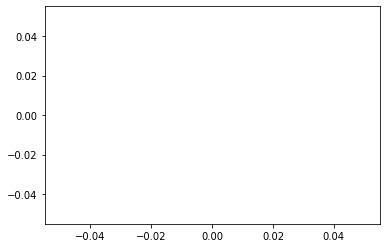

In [ ]:
max_length = -1
for curve in learning_curves:
  if len(curve) > max_length:
    max_length = len(curve)
padded_curves = [c+[c[-1] for pad in range(max_length-len(c))] for c in learning_curves]
av_curve = np.mean(padded_curves, axis=0)
plot(av_curve) 